<a href="https://colab.research.google.com/github/suchy1713/ML-Learning/blob/master/4_unsupervised_dl/rbm_theano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# -*- coding: utf-8 -*-
"""ann_theano_model.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1xwn7DYqyEDKrdQ9atMc6LRIAOWGyLKMV
"""

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from theano.tensor.shared_randomstreams import RandomStreams

def init_weights(M1, M2):
    return np.random.randn(M1, M2)/np.sqrt(M1)

def error_rate(p, t):
    return np.mean(p != t)

class RBM(object):
    def __init__(self, M, an_id):
        self.M = M
        self.id = str(an_id)
        self.rng = RandomStreams()

    def fit(self, X, learning_rate=0.1, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        n_batches = N//batch_sz

        W0 = init_weights(D, self.M)
        self.W = theano.shared(W0, 'W_' + self.id)
        self.c = theano.shared(np.zeros(self.M), 'c_'+self.id)
        self.b = theano.shared(np.zeros(D), 'b_'+self.id)
        self.params = [self.W, self.c, self.b]
        self.forward_params = [self.W, self.b]

        self.dW = theano.shared(np.zeros(W0.shape), 'dW_' + self.id)
        self.dc = theano.shared(np.zeros(self.M), 'dc_'+self.id)
        self.db = theano.shared(np.zeros(D), 'db_'+self.id)
        self.dparams = [self.dW, self.dc, self.db]
        self.dforward_params = [self.dW, self.db]

        X_in = T.matrix('X_in_'+self.id)

        H = T.nnet.sigmoid(X_in.dot(self.W) + self.c)
        self.hidden_op = theano.function(
            inputs = [X_in],
            outputs = H
        )

        X_hat = self.forward_output(X_in)
        cost = -(X_in*T.log(X_hat) + (1-X_in)*T.log(1-X_hat)).mean()
        cost_op = theano.function(
            inputs = [X_in],
            outputs = cost
        )

        H = self.sample_h_given_v(X_in)
        X_sample = self.sample_v_given_h(H)
        objective = T.mean(self.free_energy(X_in)) - T.mean(self.free_energy(X_sample))

        updates = [(p, p - learning_rate*T.grad(objective, p, consider_constant=[X_sample])) for p in self.params]
        train_op = theano.function(
            inputs = [X_in],
            updates=updates
        )

        costs = []
        print('Training RBM ', self.id)
        for i in range(epochs):
            print('epoch ', i, end=' ')
            X = shuffle(X)
            for j in range(n_batches):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                c = cost_op(batch)
                costs.append(c)

            print('cost: ', c)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def free_energy(self, V):
        return -V.dot(self.b) - T.sum(T.log(1 + T.exp(V.dot(self.W) + self.c)), axis=1)

    def sample_h_given_v(self, V):
        p_h_given_v = T.nnet.sigmoid(V.dot(self.W) + self.c)
        return self.rng.binomial(size=p_h_given_v.shape, n=1, p=p_h_given_v)

    def sample_v_given_h(self, H):
        p_v_given_h = T.nnet.sigmoid(H.dot(self.W.T) + self.b)
        return self.rng.binomial(size=p_v_given_h.shape, n=1, p=p_v_given_h)

    def forward_hidden(self, X):
        return T.nnet.sigmoid(X.dot(self.W) + self.c)

    def forward_output(self, X):
        Z = self.forward_hidden(X)
        return T.nnet.sigmoid(Z.dot(self.W.T) + self.b)

class DNN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layers = []
        count = 0
        for M in hidden_layer_sizes:
            ae = RBM(M, count)
            self.hidden_layers.append(ae)
            count += 1

    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.1, mu=0.99, reg=0, epochs=1, batch_sz=100):
        pretrain_epochs = int(pretrain)

        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=2, show_fig=False)
            current_input = ae.hidden_op(current_input)

        N = len(Y)
        K = len(set(Y))
        W0 = init_weights(self.hidden_layers[-1].M, K)
        self.W = theano.shared(W0, 'W_lr')
        self.b = theano.shared(np.zeros(K), 'b_lr')

        self.params = [self.W, self.b]
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        self.dW = theano.shared(np.zeros((self.hidden_layers[-1].M, K)), 'dW_lr')
        self.db = theano.shared(np.zeros(K), 'db_lr')

        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.dforward_params

        X_in = T.matrix('X_in')
        targets = T.ivector('targets')
        pY = self.forward(X_in)

        reg_cost = T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(pY.shape[0]), targets])) + reg*reg_cost
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs = [X_in, targets],
            outputs = [cost, prediction]
        )

        updates = [
                   (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
             (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]

        train_op = theano.function(
            inputs = [X_in, targets],
            updates = updates
        )

        n_batches = N // batch_sz
        costs = []

        print('Supervised learning:')
        for i in range(epochs):
            print('epoch ', i+1, end=' ')
            X, Y = shuffle(X, Y) 

            for j in range(n_batches):
                X_batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Y_batch = Y[j*batch_sz:(j*batch_sz + batch_sz)]

                train_op(X_batch, Y_batch)
                cost, prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(prediction, Ytest)
                costs.append(cost)
            print('Cost: ', cost, ' Error: ', error)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

Training RBM  0
epoch  0 cost:  0.1871614549084455
epoch  1 cost:  0.1563423601581786
Training RBM  1
epoch  0 cost:  0.46964056316771463
epoch  1 cost:  0.4543796924360488
Training RBM  2
epoch  0 cost:  0.25858504509066776
epoch  1 cost:  0.24298880647339652
Supervised learning:
epoch  1 

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Cost:  1.159760499246078  Error:  0.344
epoch  2 Cost:  0.6254249806213423  Error:  0.207
epoch  3 Cost:  0.4658623770561258  Error:  0.126
epoch  4 Cost:  0.5180095189933905  Error:  0.144
epoch  5 Cost:  0.40935474347635975  Error:  0.115
epoch  6 Cost:  0.44850809239064243  Error:  0.119
epoch  7 Cost:  0.38482102360009485  Error:  0.089
epoch  8 Cost:  0.38293603092756856  Error:  0.083
epoch  9 Cost:  0.37048481034802483  Error:  0.073
epoch  10 Cost:  0.3793978628065174  Error:  0.075


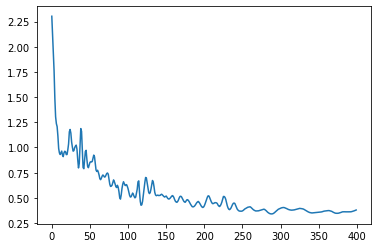

In [13]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = shuffle(x_train, y_train)
x_test, y_test = shuffle(x_test, y_test)
x_train, x_test, y_train, y_test = x_train[:4000, :], x_test[:1000, :], y_train[:4000], y_test[:1000]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
y_train, y_test = y_train.astype(np.int32), y_test.astype(np.int32)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

dnn = DNN([1000, 750, 500])
dnn.fit(x_train, y_train, x_test, y_test, epochs=10)